## Dependencies

In [ ]:
!pip install llama-index transformers pyvis networkx

In [ ]:

!wget https://huggingface.co/TheBloke/StableBeluga-13B-GGML/resolve/main/stablebeluga-13b.ggmlv3.q6_K.bin

--2023-07-29 10:13:11--  https://huggingface.co/TheBloke/Nous-Hermes-llama-2-7b-GGML/resolve/main/nous-hermes-llama-2-7b.ggmlv3.q8_0.bin
Resolving huggingface.co (huggingface.co)... 13.224.249.43, 13.224.249.119, 13.224.249.44, ...
Connecting to huggingface.co (huggingface.co)|13.224.249.43|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /TheBloke/Nous-Hermes-Llama-2-7B-GGML/resolve/main/nous-hermes-llama-2-7b.ggmlv3.q8_0.bin [following]
--2023-07-29 10:13:11--  https://huggingface.co/TheBloke/Nous-Hermes-Llama-2-7B-GGML/resolve/main/nous-hermes-llama-2-7b.ggmlv3.q8_0.bin
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/3d/9c/3d9cca00288ca7ac282ab1db700d6adf5d09477770cdc665ff34607a2843ce31/e19ca1d4ac199c49d3748afe4b655797c5aea4001525a70d878edd658e1df1b6?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27nous-hermes-llama-2-7b.ggml

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install --upgrade --force-reinstall llama-cpp-python --no-cache-dir -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 163.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 138.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.1 which is incompatible.


In [ ]:
from langchain.llms import LlamaCpp
from langchain import PromptTemplate, LLMChain
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [ ]:
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])


In [ ]:
n_gpu_layers =40  # Change this value based on your model and your GPU VRAM pool.
n_batch = 512  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.

# Make sure the model path is correct for your system!
llm = LlamaCpp(
    model_path="stablebeluga-13b.ggmlv3.q6_K.bin",
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    callback_manager=callback_manager,
    verbose=True,
    n_ctx=512
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


## Building the Graph

Here, we will construct the index, as well as leveraging `rebel` to extract triplets.

In [ ]:
texts = '''India, officially the Republic of India (ISO: Bhārat Gaṇarājya),[22] is a country in South Asia. It is the seventh-largest country by area; the most populous country as of June 2023;[23][24] and from the time of its independence in 1947, the world's most populous democracy.[25][26][27] Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west;[j] China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is in the vicinity of Sri Lanka and the Maldives; its Andaman and Nicobar Islands share a maritime border with Thailand, Myanmar, and Indonesia.'''


In [ ]:
from langchain.llms import OpenAI
from langchain.indexes import GraphIndexCreator
from langchain.chains import GraphQAChain
from langchain.prompts import PromptTemplate
from langchain.graphs.networkx_graph import KnowledgeTriple

llm.temperature = 0

index_creator = GraphIndexCreator(llm=llm)
f_index_creator = GraphIndexCreator(llm=llm)

final_graph = f_index_creator.from_text('')

for text in texts.split("."):
  triples = index_creator.from_text(text)
  for (node1, relation, node2) in triples.get_triples():
    final_graph.add_triple(KnowledgeTriple(node1, relation, node2))




Llama.generate: prefix-match hit


 NONE
END OF EXAMPLE

Llama.generate: prefix-match hit


 (India, is a, country)<|>(India, is in, South Asia)

Llama.generate: prefix-match hit


 (India, is the seventh-largest country by area)<|>(India, is the most populous country as of June 2023)<|>(India, from the time of its independence in 1947, is the world's most populous democracy)
END OF EXAMPLE

Llama.generate: prefix-match hit


 NONE
END OF EXAMPLE

Llama.generate: prefix-match hit


 (Indian Ocean, is near, Sri Lanka)<|>(Indian Ocean, is near, Maldives)<|>(Andaman and Nicobar Islands, shares maritime border with, Thailand)<|>(Andaman and Nicobar Islands, shares maritime border with, Myanmar)<|>(Andaman and Nicobar Islands, shares maritime border with, Indonesia)
END OF EXAMPLE

Llama.generate: prefix-match hit


 NONE
END OF EXAMPLE

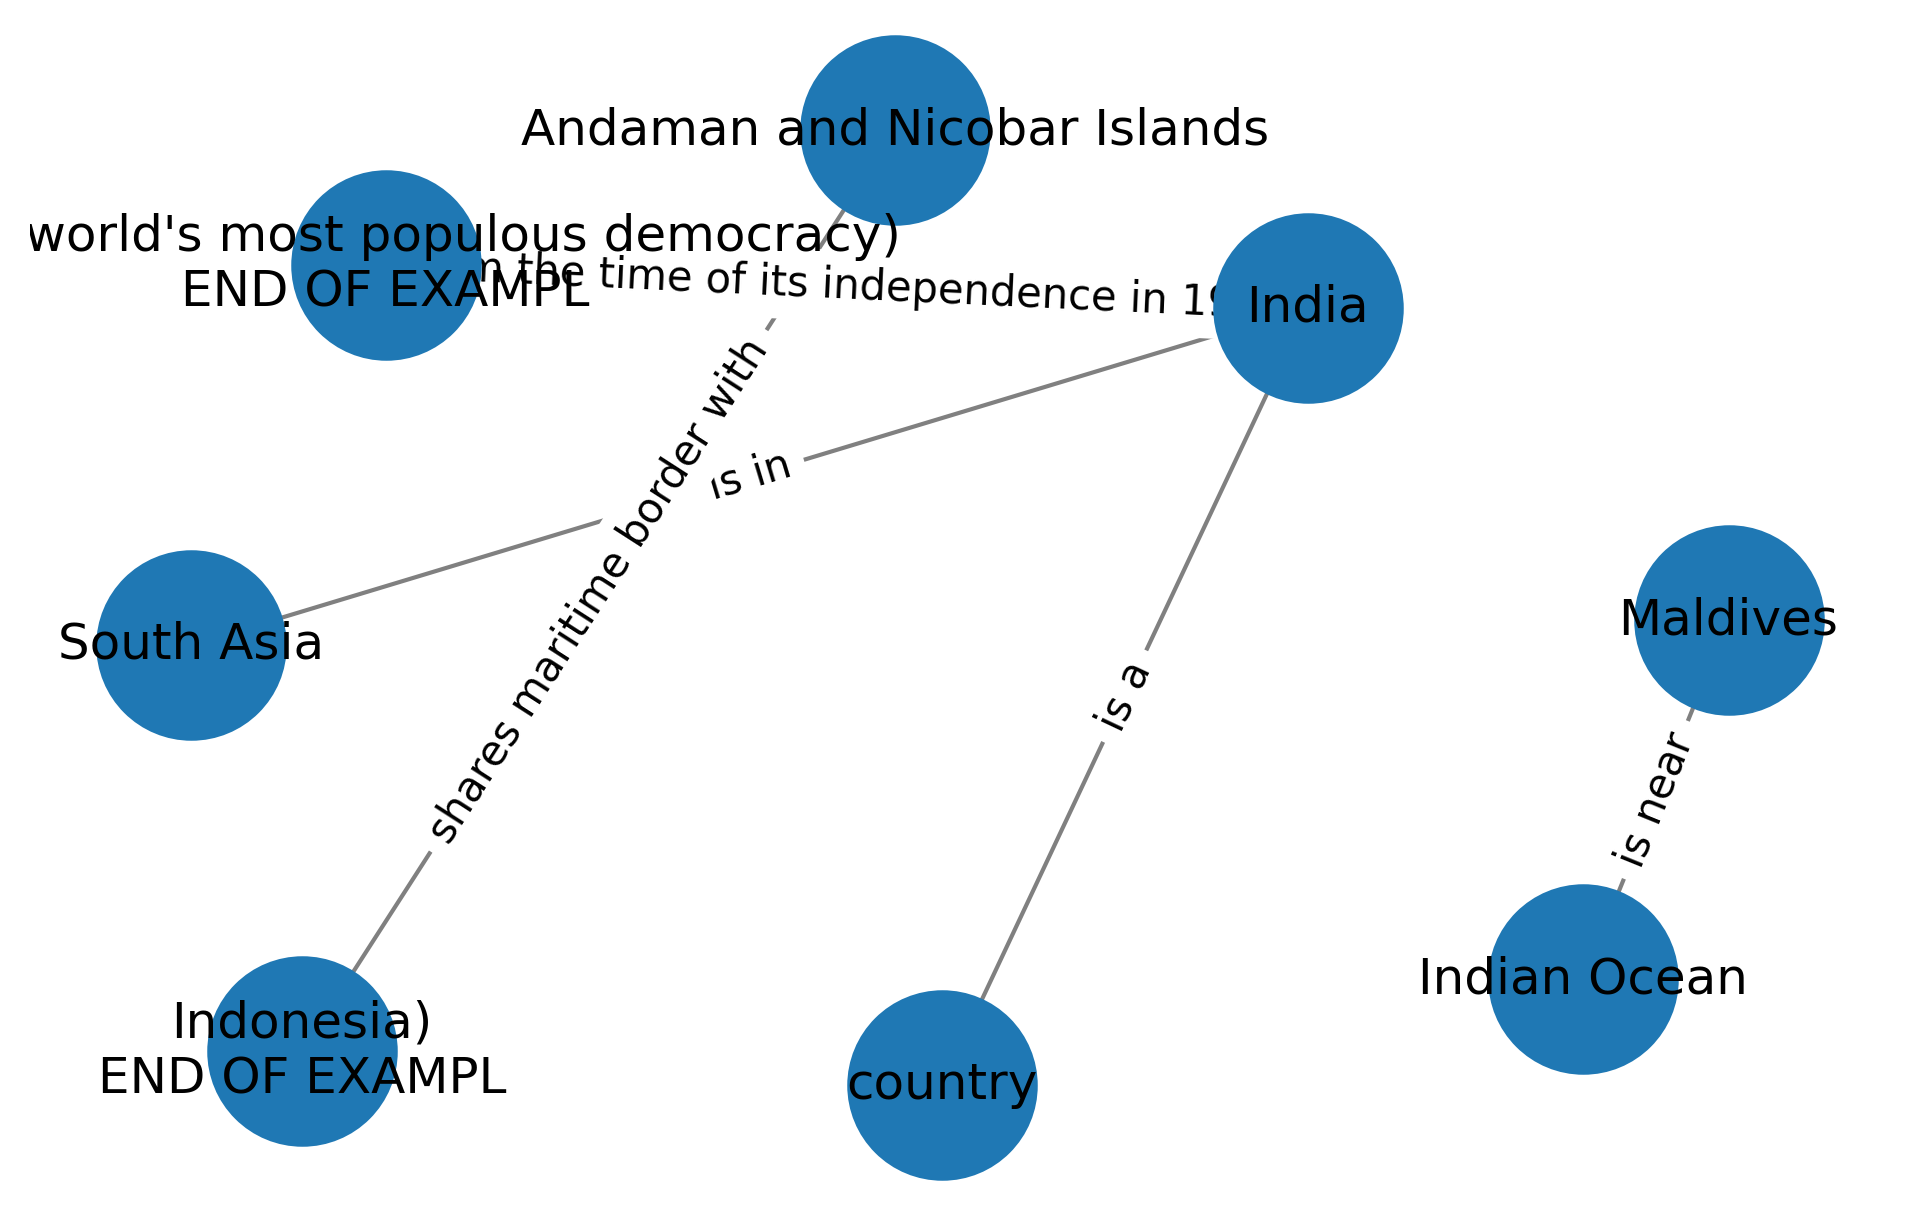

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.DiGraph()
G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in final_graph.get_triples())

# Plot the graph
plt.figure(figsize=(8,5), dpi=300)
pos = nx.spring_layout(G, k=3, seed=0)

nx.draw_networkx_nodes(G, pos, node_size=2000)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Display the plot
plt.axis('off')
plt.show()

In [ ]:
chain = GraphQAChain.from_llm(llm, graph=final_graph, verbose=True)
llm.temperature = 0
chain.run('India is in?')



> Entering new GraphQAChain chain...


Llama.generate: prefix-match hit


 IndiaEntities Extracted:
 India
Full Context:
India country is a
India South Asia is in
India is the world's most populous democracy)
END OF EXAMPL from the time of its independence in 1947


Llama.generate: prefix-match hit


 South Asia
> Finished chain.


' South Asia'

In [ ]:
chain.run('What is India?')



> Entering new GraphQAChain chain...


Llama.generate: prefix-match hit


 IndiaEntities Extracted:
 India
Full Context:
India country is a
India South Asia is in
India is the world's most populous democracy)
END OF EXAMPL from the time of its independence in 1947


Llama.generate: prefix-match hit


 India is a country located in South Asia. It gained independence from British rule in 1947 and is known for being the world's most populous democracy.
> Finished chain.


" India is a country located in South Asia. It gained independence from British rule in 1947 and is known for being the world's most populous democracy."

## Visualization

We can use networkx to display the graph within our notebook!

While not all triplets are perfect or correct, `rebel` does a good job of extracting appropriate `subj` values, which helps the query engine locate the text chunks for answering the query!

In [ ]:
from pyvis.network import Network

net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(G)
net.show('/content/example.html')

import IPython
IPython.display.HTML(filename='/content/example.html')


/content/example.html
